In [1]:
import numpy as np
import inspect
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from math import exp, sqrt
from sympy import *
from datetime import datetime

# Лабораторная №2

## Utils

### Полезные ссылки

- [условие](http://mathdep.ifmo.ru/wp-content/uploads/2021/03/lab_2_optimization.pdf)
- [метод ньютона](http://fourier.eng.hmc.edu/e176/lectures/ch3/node6.html)

### Одномерные методы поиска

In [2]:
def get_value(fdict, f, x: float):
    if (x not in fdict):
        v = f(x)
        fdict[x] = v
    else:
        v = fdict[x]
    
    return v, fdict

In [3]:
def get_next_interval_base(fdict, f, a: float, b: float, x1: float, x2: float):
    v1, fdict = get_value(fdict, f, x1)
    v2, fdict = get_value(fdict, f, x2)
    
    if (v1 < v2):
        return fdict, a, x2
    elif (v1 > v2):
        return fdict, x1, b
    else:
        return fdict, x1, x2

In [4]:
def bisection_search(f, a, b, verbose=False, eps=1e-3):
    fdict = {}
    step = 0
    delta = eps/4
    
    if (verbose):
        print_iter(step, a, b, 0)
        
    while (abs(a - b) > eps):
        pred = a-b
        x1 = ((a + b) / 2) - delta
        x2 = ((a + b) / 2) + delta
        fdict, a, b = get_next_interval_base(fdict, f, a, b, x1, x2)
        step += 1
        if (verbose):
            print_iter(step, a, b, (a-b)/pred)
       
    return (a+b)/2, step, len(fdict)

In [5]:
def fib_search(f, a, b, verbose=False, eps=1e-3):
    fdict = {}
    
    n = 0
    while (fib(n+2) <= (b-a)/eps):
        n += 1
    
    if (verbose):
        print_iter(0, a, b, 1)
    x1 = a + fib(n)*(b-a)/fib(n+2)
    x2 = a + fib(n+1)*(b-a)/fib(n+2)
    step = 1
    
    while (abs(a - b) > eps):
        pred = a-b
        fdict, a, b = get_next_interval_base(fdict, f, a, b, x1, x2)
        if (a == x1):
            x1 = x2
            x2 = a + fib(n-step+2)*(b-a)/fib(n-step+3)
        else:
            x2 = x1
            x1 = a + fib(n-step+1)*(b-a)/fib(n-step+3)
        if (verbose):
            print_iter(step, a, b, (a-b)/pred)
        step += 1
        
    return (a+b)/2, step-1, len(fdict)

### Finding derivative

In [6]:
def get_dfs(func):
    arg_symbols = symbols(inspect.getfullargspec(func).args)
    sym_func = func(*arg_symbols)

    return [lambdify(arg_symbols, sym_func.diff(a)) for a in arg_symbols]

In [7]:
def calc_df(func, params):
    dfs = get_dfs(func)
    res = []
    for df in dfs:
        res.append(df(*params))
    return res

In [8]:
def calc_inv_hessian(func, params):
    dfs = get_dfs(func)
    n = len(dfs)
    
    h = [[0 for x in range(n)] for y in range(n)] 
    for i in range(len(dfs)):
        h[i] = get_dfs(dfs[i])
    
    for i in range(n):
        for j in range(n):
            h[i][j] = h[i][j](*params)

    inv_h = np.linalg.inv(h)
    
    return inv_h 

In [9]:
def make_hessian_positive(h):
    eps = 1e-3
    
    while (np.linalg.norm(h) < 0):
        h += eps*np.eye(*h.shape)
        eps *= 2
        
    return h

### Visualization methods

In [10]:
def print_res(res, step, time, xs):
    print('Result:', res)
    print('Total iterations: ', step)
    print('Time: ', time)
    print('Steps: ', xs)

In [11]:
def draw_countors_plot_with_steps(coords, f, name, classic = True):
    x_min = -8
    y_min = -8
    x_max = 5
    y_max = 5
    delta = 20
    
    
    x = np.linspace(x_min, x_max, delta)
    y = np.linspace(y_min, y_max, delta)
    X, Y = np.meshgrid(x, y)
    
    if (classic):
        z = f
    else:
        z = get_function_from_symmetric_matrix(f) 
        
    Z = z(X, Y)

    contours = plt.contour(X, Y, Z, 3, colors='black')
    plt.clabel(contours, inline=True, fontsize=12)
    plt.imshow(Z, extent=[x_min, x_max, y_min, y_max], origin='lower',
               cmap='RdGy', alpha=0.5)
    plt.colorbar();

    cx, cy = zip(*coords)
    plt.plot(cx, cy, color='black', marker='o')
    plt.savefig('images/' + name + '_steps.png')
    plt.show()

### Test data

In [12]:
f = [
    lambda x, y: 100*(y-x)**2 + (1-x)**2,
    lambda x, y: 100*(y-x**2)**2 + (1-x)**2,
    lambda x, y: -(2*exp**(-((x-1)/2)**2 - (y-1)**2) + 3*exp**(-((x-2)/3)**2 - (((y-3)/2)**2)))
]

x = [
    [2., 2.],
    [1., 0.],
    [-1., -1.],
    [5., 3.],
    [-2., 4.]
]

colors = ['red', 'blue', 'green']

## Метод сопряженных направлений

In [13]:
def conjugate_vecs_method(f, x, N=1000, optimizer=bisection_search, eps=1e-5):
    step = 0
    xs = [x]
    start_time = datetime.now()
    
    x_prev = x
    w_prev = np.array(-1) * calc_df(f, x)
    p_prev = w_prev
    step += 1    
    
    while(abs(np.linalg.norm(w_prev)) > eps and step < N):
        
        wk = np.array(-1) * calc_df(f, x_prev)
        gamma = (np.linalg.norm(wk)**2)/(np.linalg.norm(w_prev)**2)
        pk = wk + gamma * p_prev
        
        psi = lambda chi: f(*(x_prev + chi * p_prev))
        hk, _, _ = optimizer(psi, 0, 1, False, eps)
        
        xk = x_prev + hk * pk
        
        x_prev = xk
        w_prev = wk
        p_prev = pk
        
        step += 1
        xs.append(list(x_prev))      
        
        
    new_step = 0
    new_xs = []
    if (step == N):
        x, new_step, time, new_xs = conjugate_vecs_method(f, xk)
        
    end_time = datetime.now()
    time = (start_time - end_time).seconds
    
    return x_prev, step + new_step, time, xs + new_xs

In [14]:
res, steps, time, coords = conjugate_vecs_method(f[0], [2.,2.])

print_res(res, steps, time, coords)

Result: [0.94829267 0.94315855]
Total iterations:  1187
Time:  86396
Steps:  [[2.0, 2.0], [1.9801918201828004, 2.0], [1.9801138176937487, 1.999982539726934], [1.9800441140303366, 1.999947437010087], [1.9799830223567128, 1.9998946424108712], [1.7666915572892528, 1.7124626249595383], [1.7659276439763751, 1.7115544989527167], [1.7651053750312407, 1.710689931104466], [1.3553614987070817, 1.3290952489772523], [1.260061142754697, 1.260096183088191], [1.2596399420820514, 1.2600013979808744], [1.2543659619426013, 1.258961494446947], [1.254345648699721, 1.258953081719484], [1.2543270270019813, 1.2589405547664567], [1.2463439770120295, 1.251063042038014], [1.0217056116279493, 0.9436958454581716], [1.0144778267289776, 0.9339693554200262], [1.0067160837990352, 0.9236909500287604], [0.9983964181205555, 0.9128438968705499], [0.9894959207967139, 0.9014132783882522], [0.9799931227727726, 0.8893863809688755], [0.969868412364818, 0.876753105637541], [0.9591044822282628, 0.8635063943959278], [0.947686799

<ipython-input-12-5e93abb58296>:2: RuntimeWarning: overflow encountered in double_scalars
  lambda x, y: 100*(y-x)**2 + (1-x)**2,
<lambdifygenerated-2373>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (202*x - 200*y - 2)
<lambdifygenerated-2374>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (-200*x + 200*y)
<ipython-input-12-5e93abb58296>:2: RuntimeWarning: invalid value encountered in double_scalars
  lambda x, y: 100*(y-x)**2 + (1-x)**2,


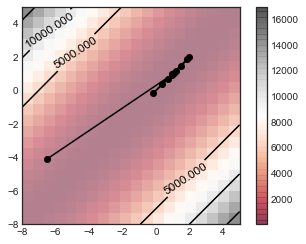

In [15]:
draw_countors_plot_with_steps(coords[0::100], f[0], 'conjugate')

## Метод Ньютона

- функция должна быть дважды дифференцируемой

In [16]:
def newtons_method(f, x, N=20, eps=1e-4):
    step = 0
    xs = [x]
    lr = 1e-3
    start_time = datetime.now()
    
    while (np.linalg.norm(calc_df(f,x)) > eps):
        h = calc_inv_hessian(f,x)
        if (np.linalg.norm(h) < 0):
            h = make_hessian_positive(h)
        
        x -= np.dot(h, calc_df(f,x))
        step += 1
        xs.append(list(x))
        
    end_time = datetime.now()
    time = (start_time - end_time).seconds
    
    return x, step, time, xs

In [17]:
res, steps, time, coords = newtons_method(f[0], [2.,2.])

print_res(res, steps, time, coords)

Result: [1. 1.]
Total iterations:  1
Time:  86399
Steps:  [[2.0, 2.0], [1.0000000000000009, 1.0000000000000009]]


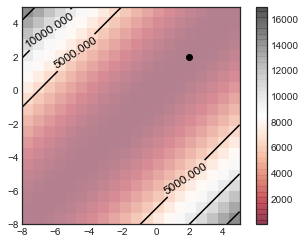

In [18]:
draw_countors_plot_with_steps(coords[0::100], f[0], 'newtons')

## Старый добрый градиентный спуск

In [19]:
def classic_gradient_descent(f, x, eps=1e-4):
    step = 0
    lr = 1e-3
    xs = [x]
    start_time = datetime.now()
    
    while (np.linalg.norm(calc_df(f,x)) > eps):
        x -= np.dot(lr, calc_df(f,x))
        step += 1
        xs.append(list(x))
        
    end_time = datetime.now()
    time = (start_time - end_time).seconds
    
    return x, step, time, xs

In [20]:
res, steps, time, coords = classic_gradient_descent(f[0], [2.,2.])

print_res(res, steps, time, coords)

Result: [1.00007068 1.00007103]
Total iterations:  9574
Time:  86354
Steps:  [[2.0, 2.0], [1.998, 2.0], [1.996404, 1.9996], [1.995050392, 1.9989608], [1.993842372816, 1.9981787184000002], [1.992721957187168, 1.9973114492832003], [1.991654411692, 1.9963935508639938], [1.9906189307030149, 1.995445723029595], [1.989603051306925, 1.994480364564279], [1.988599307855782, 1.9935049019128082], [1.9876032280514757, 1.9925237831014029], [1.9866121326053583, 1.9915396720914174], [1.9856244162373595, 1.9905541641942055], [1.984639116996254, 1.9895682146028364], [1.983655658283578, 1.98858239508152], [1.9826736943265992, 1.9875970477219316], [1.9816930176170124, 1.9866123770428652], [1.980713503466949, 1.9856285051576947], [1.9797350767981643, 1.9846455048195455], [1.9787576922488441, 1.9836634192152693], [1.9777813222576315, 1.9826822738219843], [1.976805949925987, 1.9817020835091137], [1.9758315647427602, 1.9807228567924884], [1.9748581600232205, 1.9797445983825428], [1.9738857313750384, 1.978767

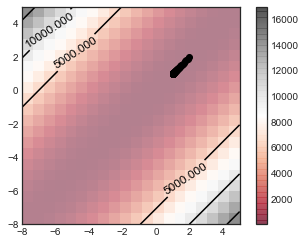

In [21]:
draw_countors_plot_with_steps(coords[0::100], f[0], 'gradient')

In [22]:
def quadratic_gradient_descent(Q, x, eps=1e-2):
    step = 0
    lr = 0.5
    coef_crush =0.5
    xs = [x]
    
    while (np.linalg.norm(Q * x) > eps):
        x -= np.linalg.norm(np.eye(len(Q)) - lr*(coef_crush**step)*Q)*np.array(x)
        step += 1
        xs.append(list(x))
        
    return x, step, xs

## Statistics

In [23]:
methods = {'conjugate_vecs_method': conjugate_vecs_method, 
           'newtons_method': newtons_method, 
           'gradient_descent': classic_gradient_descent}

<ipython-input-12-5e93abb58296>:2: RuntimeWarning: overflow encountered in double_scalars
  lambda x, y: 100*(y-x)**2 + (1-x)**2,
<lambdifygenerated-549303>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (202*x - 200*y - 2)
<lambdifygenerated-549304>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (-200*x + 200*y)
<ipython-input-12-5e93abb58296>:2: RuntimeWarning: invalid value encountered in double_scalars
  lambda x, y: 100*(y-x)**2 + (1-x)**2,
<ipython-input-13-ffbcf2e9e6d3>:14: RuntimeWarning: invalid value encountered in double_scalars
  gamma = (np.linalg.norm(wk)**2)/(np.linalg.norm(w_prev)**2)
<lambdifygenerated-551991>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (202*x - 200*y - 2)
<lambdifygenerated-551992>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (-200*x + 200*y)
<lambdifygenerated-552113>:2: RuntimeWarning: overflow encountered in double_scalars
  return (-400*x*(-x**

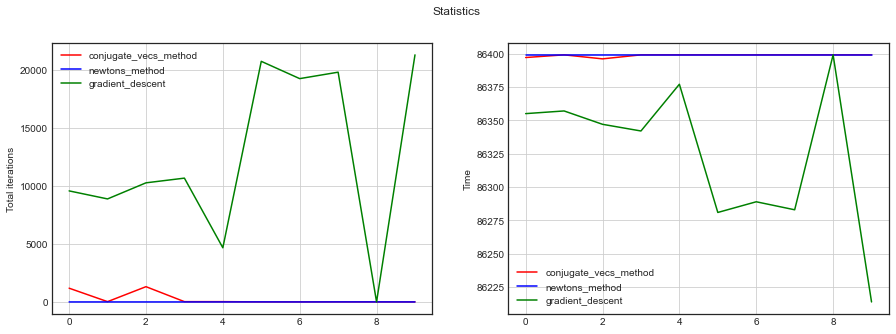

In [25]:
all_iters = {}
all_times = {}

for name, m in methods.items():
    all_iters[name] = []
    all_times[name] = []
    for f_ in f:
        for x_ in x:
            _, steps, time, _ = m(f_, x_)
            all_iters[name].append(steps)
            all_times[name].append(time)
    
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Statistics')
fig.set_figheight(5)
fig.set_figwidth(15)

i = 0
for name in methods.keys():
    ax1.plot(np.arange(0, len(all_iters[name])), all_iters[name], color = colors[i])
    i += 1
ax1.legend(methods.keys())
ax1.set_title('')
ax1.set_xlabel('')
ax1.set_ylabel('Total iterations')
ax1.grid(True)
# ax1.show()

i = 0
for name in methods.keys():
    ax2.plot(np.arange(0, len(all_times[name])), all_times[name], color = colors[i])
    i += 1
ax2.legend(methods.keys())
ax2.set_title('')
ax2.set_xlabel('')
ax2.set_ylabel('Time')
ax2.grid(True)

plt.show()


fig.savefig('images/stats.png')